# Observations and Insights

<hr>

In [1]:
# Dependencies and Setup (John)
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import calendar

# CalFresh data file path (DeJuan)
calfresh_data_path = "Resources/CalFresh Data 19 - Current.csv"
# Census data file path (Jackson)
census_data_path = "Resources/co-est2019-alldata.csv"
# us-counties data file path (Siddharth)
all_counties_path = "Resources/us-counties.csv"
CA_COVID_Counties_Path = "Resources/CA_COVID_Counties_Data.csv"
covid_merge_path = "Resources/covid_merge.csv"
Top_10_Counties_path = "Resources/Top 10 Counties By Infection.csv"
Bottom_10_Counties_path = 'Resources/Bottom 10 Counties By Infection.csv'

In [2]:
# Read the all three datasets (John)
calfresh_data = pd.read_csv(calfresh_data_path)

# rename columns. (DHall)
calfresh_data.rename(columns = {'Calendar Year' : 'Year', 'Unemployment Monthly	' : 'Unemployment', 
                                'CalFresh Households' : 'Households', 'CalFresh Persons' : 'Persons', 
                                'EBT_FSP_dollars' : 'EBT Cash'}, inplace = True)
 
# Use .drop function. Removed columns 7-8 as not needed, and index 0 (row 1). (John)
calfresh_data.drop(calfresh_data.columns[[2, 7, 8]], axis = 1, inplace = True)

# remove commas in the entire dataframe and convert number strings to a number int. (John)
calfresh_df = pd.DataFrame(calfresh_data)
calfresh_df.replace(',','', regex=True, inplace=True)

# Cconvert specific columns to number dtype (John)
calfresh_df = calfresh_df.astype({'Households': int, 'Persons': int, 'EBT Cash': int})

# convert unemployment from obj to float, removed "%", divide by 100 and round to 3 digits.
calfresh_df[calfresh_df.columns[3:]] = calfresh_df[calfresh_df.columns[3:]
                                                  ].replace('[\%,]', '', regex=True).astype(float)
calfresh_df['Unemployment Monthly'] = calfresh_df['Unemployment Monthly'].div(100).round(3)

#Filter calfreash data by 2020 and 2021 (DHall)
calfresh_data20_21 = calfresh_df[calfresh_df['Year']!=2019]

#Export Updated CSV to Resource Folder (DHall)
calfresh_data20_21.to_csv('Resources/calfresh_data20_21.csv')

calfresh_data20_21

,County,Month,Year,Unemployment Monthly,Households,Persons,EBT Cash
708,Statewide,January,2020,0.043,2176109.0,4075962.0,500169011.0
709,Alameda,January,2020,0.031,65302.0,112881.0,13678807.0
710,Alpine,January,2020,0.046,77.0,126.0,14377.0
711,Amador,January,2020,0.047,1496.0,2588.0,305508.0
712,Butte,January,2020,0.056,17028.0,28648.0,3503997.0
...,...,...,...,...,...,...,...
1529,Tulare,February,2021,0.114,45068.0,101481.0,17778143.0
1530,Tuolumne,February,2021,0.087,3170.0,4907.0,786603.0
1531,Ventura,February,2021,0.068,36565.0,67207.0,11082712.0
1532,Yolo,February,2021,0.068,0.0,0.0,3572432.0


In [3]:
#CA County Data (Jackson)
#Data cleanup: Separate date into 3 columns, MONTH, DATE, YEAR. Isolate counties to CA. Drop FIPS column. 
all_counties = pd.read_csv(all_counties_path,index_col=0, parse_dates=True)

#Drop FIPS column
all_counties_df = pd.DataFrame(all_counties).drop(["fips"], axis=1)

#Isolate counties to CA 
CA_counties_df = all_counties_df[all_counties_df["state"] == "California"]

CA_counties_df.reset_index(inplace=True)
CA_counties_df = CA_counties_df.astype({'date': str})
CA_counties_df[["year", "month", "day"]] = CA_counties_df["date"].str.split("-", expand = True)
CA_counties_df = CA_counties_df.astype({'deaths': int, 'year': int, 'month': int, 'day': int})
CA_counties_df['month'] =  CA_counties_df['month'].apply(lambda x: calendar.month_name[x])

CA_counties_df.pop('date')  # Deleted original date column

CA_counties_df

,county,state,cases,deaths,year,month,day
0,Orange,California,1,0,2020,January,25
1,Los Angeles,California,1,0,2020,January,26
2,Orange,California,1,0,2020,January,26
3,Los Angeles,California,1,0,2020,January,27
4,Orange,California,1,0,2020,January,27
...,...,...,...,...,...,...,...
23292,Tulare,California,49469,831,2021,April,22
23293,Tuolumne,California,4091,64,2021,April,22
23294,Ventura,California,80398,1002,2021,April,22
23295,Yolo,California,13606,200,2021,April,22


In [4]:
# groupby multiple column and sum by cases; convert groupby into dataframe using .to_frame() (John)
#county_group = CA_counties_df.groupby(['county', 'year', 'month'])["cases"].apply(lambda x : x.astype(
#    int).sum()).to_frame().reset_index()
county_cases = CA_counties_df.groupby(['county', 'year', 'month'])["cases"].apply(lambda x : x.astype(
    int).sum()).to_frame().reset_index()
county_cases

,county,year,month,cases
0,Alameda,2020,April,30470
1,Alameda,2020,August,463338
2,Alameda,2020,December,1247644
3,Alameda,2020,July,268879
4,Alameda,2020,June,136574
...,...,...,...,...
810,Yuba,2020,September,32400
811,Yuba,2021,April,133585
812,Yuba,2021,February,156493
813,Yuba,2021,January,146941


In [5]:
county_deaths = CA_counties_df.groupby(['county', 'year', 'month'])["deaths"].apply(lambda x : x.astype(
    int).sum()).to_frame().reset_index()
# merge two county data sets on county, year and month
county_merge = pd.merge(county_cases, county_deaths, how='left', left_on =[
    'county', 'year', 'month'], right_on =['county', 'year', 'month'])
#CA_counties_df.to_csv("Resources/CA_County_Data.csv")
#Updated Columns to Caps to match in Merging with CalFresh data (Dhall)

county_merge.rename(columns = {'county' : 'County', 'year' : 'Year', 
                                'month' : 'Month', 'cases' : 'Cases', 
                                'deaths' : 'Deaths'}, inplace = True)

county_merge

,County,Year,Month,Cases,Deaths
0,Alameda,2020,April,30470,988
1,Alameda,2020,August,463338,6785
2,Alameda,2020,December,1247644,17659
3,Alameda,2020,July,268879,4909
4,Alameda,2020,June,136574,3458
...,...,...,...,...,...
810,Yuba,2020,September,32400,207
811,Yuba,2021,April,133585,958
812,Yuba,2021,February,156493,983
813,Yuba,2021,January,146941,821


In [6]:
# merge two CalFresh and county_merge datasets on county, year and month
covid_merge = pd.read_csv(covid_merge_path)

covid_merge.head()


,County,Month,Year,Unemployment Monthly,Households,Persons,EBT Cash,Cases,Deaths
0,Alameda,January,2020,0.031,65302,112881,13678807,0,0
1,Alameda,February,2020,0.030,65156,112458,13629862,0,0
2,Alameda,March,2020,0.038,66424,114173,13937791,334,7
3,Alameda,April,2020,0.141,76979,126157,15822035,1624,63
4,Alameda,May,2020,0.135,82572,134219,17104593,3411,103


In [22]:
# Combine columns Year and Month into single column of Date (John)
covid_merge = pd.read_csv(covid_merge_path, parse_dates= {'Date' : ['Year','Month']})
covid_merge.head(25)

,Date,County,Unemployment Monthly,Households,Persons,EBT Cash,Cases,Deaths
0,2020-01-01,Alameda,0.031,65302,112881,13678807,0,0
1,2020-02-01,Alameda,0.030,65156,112458,13629862,0,0
2,2020-03-01,Alameda,0.038,66424,114173,13937791,334,7
3,2020-04-01,Alameda,0.141,76979,126157,15822035,1624,63
4,2020-05-01,Alameda,0.135,82572,134219,17104593,3411,103
5,2020-06-01,Alameda,0.134,86632,141850,17778873,5985,135
6,2020-07-01,Alameda,0.120,86626,139604,17423995,11324,182
7,2020-08-01,Alameda,0.098,86097,139609,17247406,18208,258
8,2020-09-01,Alameda,0.093,85083,143675,16651321,21404,412
9,2020-10-01,Alameda,0.079,81670,138417,16524612,23897,464


In [8]:
# isolate to Alameda counties and rename column 3 (John)
covid_county = covid_merge[covid_merge["County"] == "Alameda"]
covid_county = covid_county.rename(columns={'Unemployment Monthly': 'Unemploy_Rate'})

# adding column with population as a fixed value
covid_county['Population'] = pd.Series([1671329 for x in range(len(covid_county.index))])
# Calculate unemployment #s based on 'Unemploy%', create new column round decimal to 0 (John)
covid_county['Unemployed'] = covid_county.apply(lambda row: row.Unemploy_Rate * 
                                                row.Population, axis = 1)
covid_county.Unemployed = covid_county.Unemployed.round(0)
covid_county.head()

,Date,County,Unemploy_Rate,Households,Persons,EBT Cash,Cases,Deaths,Population,Unemployed
0,2020-01-01,Alameda,0.031,65302,112881,13678807,0,0,1671329,51811.0
1,2020-02-01,Alameda,0.030,65156,112458,13629862,0,0,1671329,50140.0
2,2020-03-01,Alameda,0.038,66424,114173,13937791,334,7,1671329,63511.0
3,2020-04-01,Alameda,0.141,76979,126157,15822035,1624,63,1671329,235657.0
4,2020-05-01,Alameda,0.135,82572,134219,17104593,3411,103,1671329,225629.0


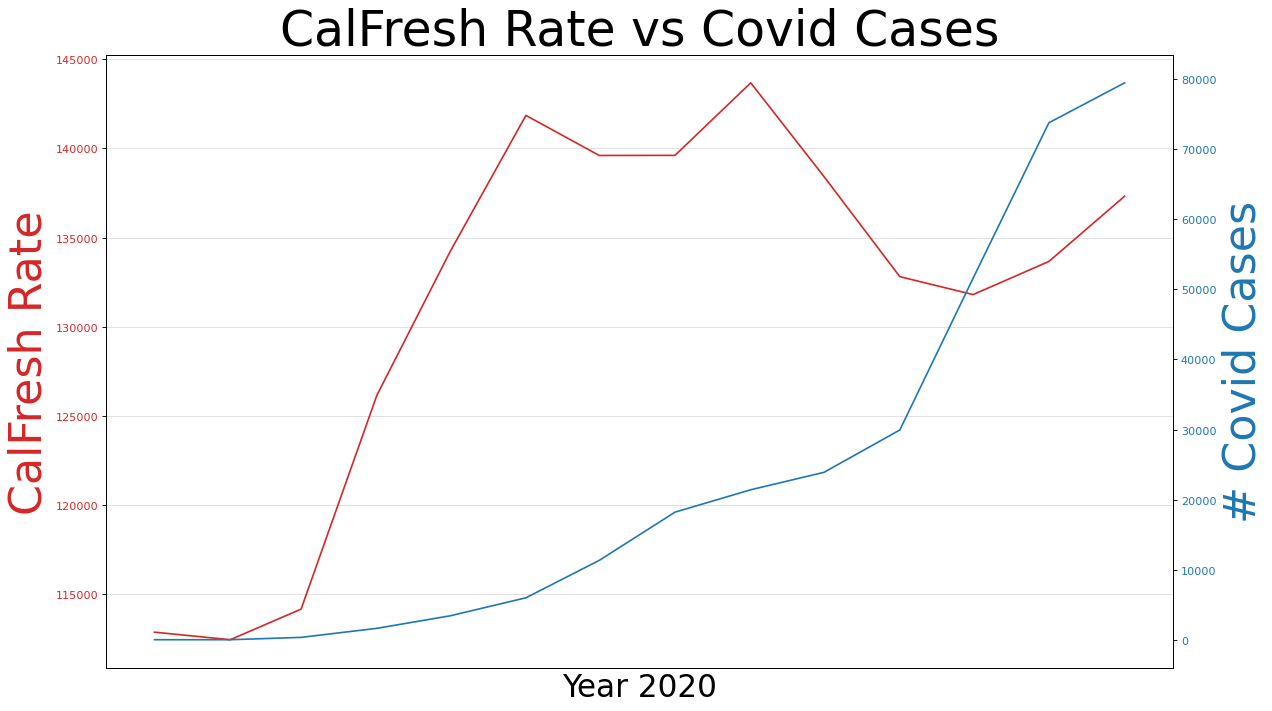

In [9]:
#Plot rise in COVID-19 vs rise in CalFresh disbursement (John)
x = covid_county['Date']
y1 = covid_county['Persons']
y2 = covid_county['Cases']

# line plot1 (Left Y-axis)
fig, ax1 = plt.subplots(1,1,figsize=(16,9), dpi= 80)
ax1.plot(x, y1, color='tab:red')

# line plot2 (right Y-Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, y2, color='tab:blue')

# Formatting
# ax1 (left Y axis)
ax1.set_xlabel('Year 2020', fontsize=28)
ax1.tick_params(axis='x', rotation=0, labelsize=28)
ax1.set_ylabel('CalFresh Rate', color='tab:red', fontsize=40)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("# Covid Cases", color='tab:blue', fontsize=40)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_xticks(np.arange(0, len(x), 60))
ax2.set_xticklabels(x[::60], rotation=90, fontdict={'fontsize':28})
ax2.set_title("CalFresh Rate vs Covid Cases", fontsize=44)
fig.tight_layout()
#plt.show()
plt.savefig('Resources/cal_covid_rate.png')

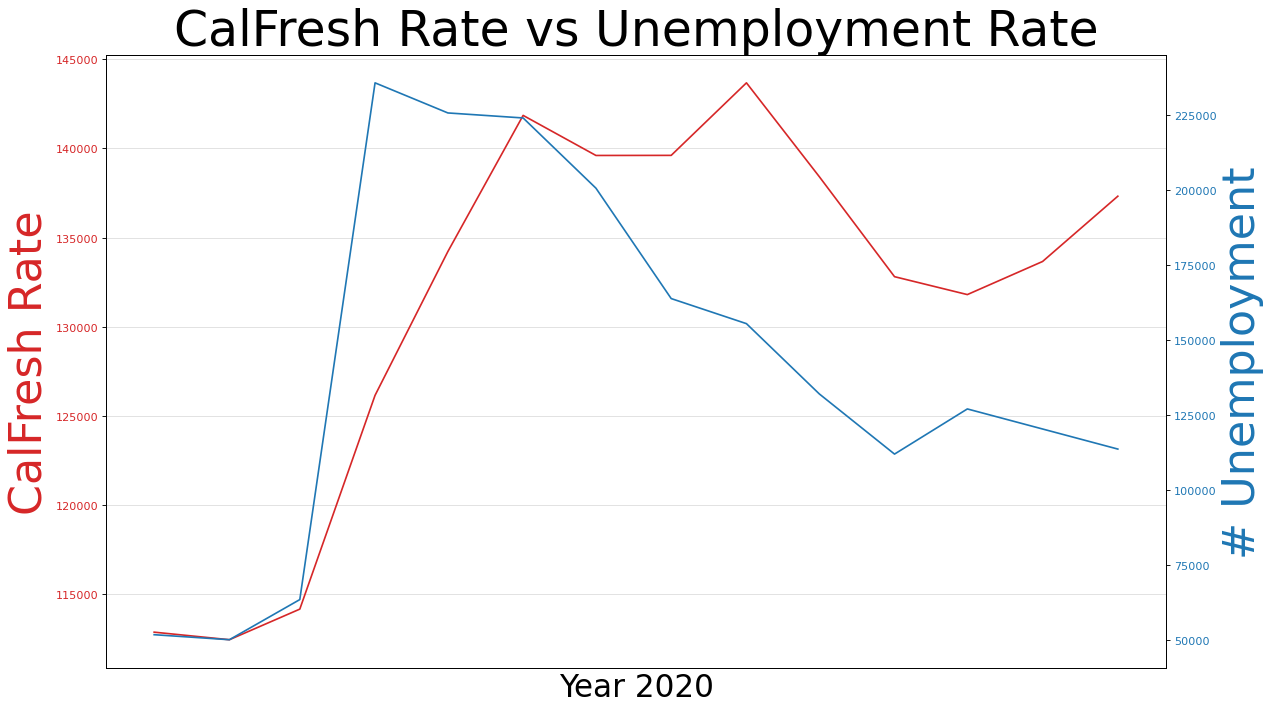

In [10]:
#Plot rise in Unemployment vs rise in CalFresh disbursement (John)
x = covid_county['Date']
y1 = covid_county['Persons']
y2 = covid_county['Unemployed']

# line plot1 (Left Y-axis)
fig, ax1 = plt.subplots(1,1,figsize=(16,9), dpi= 80)
ax1.plot(x, y1, color='tab:red')

# line plot2 (right Y-Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, y2, color='tab:blue')

# Formatting
# ax1 (left Y axis)
ax1.set_xlabel('Year 2020', fontsize=28)
ax1.tick_params(axis='x', rotation=0, labelsize=28)
ax1.set_ylabel('CalFresh Rate', color='tab:red', fontsize=40)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("# Unemployment", color='tab:blue', fontsize=40)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_xticks(np.arange(0, len(x), 60))
ax2.set_xticklabels(x[::60], rotation=90, fontdict={'fontsize':28})
ax2.set_title("CalFresh Rate vs Unemployment Rate", fontsize=44)
fig.tight_layout()
#plt.show()
plt.savefig('Resources/cal_covid_unemply.png')

In [11]:
# Filter to show necessary columns adn rename columns to use initial Caps.
census_data = pd.read_csv(census_data_path)
census_data.rename(columns = {'STNAME' : 'State', 'CTYNAME' : 'County', 
                              'POPESTIMATE2019' : 'Population'}, inplace = True)
census_df = pd.DataFrame(census_data)

# filter rows in state that equal California and required columns (Siddharth)
census_ca = census_df.loc[census_df['State'] == 'California']
census_filtered = census_ca[['State', 'County', 'Population', 'DEATHS2019']]
# Deleted original DEATHS2019 and 'State' column
census_filtered.pop('DEATHS2019') 
census_filtered.pop('State') 

#Write Census Data to CSV
census_filtered.to_csv('Resources/census_filtered.csv')
census_filtered.head()

,County,Population
190,California,39512223
191,Alameda County,1671329
192,Alpine County,1129
193,Amador County,39752
194,Butte County,219186


In [12]:
# 14 Month Overall data for counties worst hit with Covid cases Jan 2020 - Feb 2021
Top_10_Counties = pd.read_csv(Top_10_Counties_path)
Top_10_Counties   

,County,Unemployment 14 - Month Average,Total Households,Total Persons,Total EBT Benefits,Total Cases 14 - Months,Total COVID Deaths 14 - Months,2019 Census Pop,Rate Of COVID Infection,Rate of COVID Related Death
0,Los Angeles,0.131,10729649,18390156,2413142280,4661814,85511,10039107,0.4644,0.0085
1,Riverside,0.098,1786802,3544543,452601902,1074629,15368,2470546,0.4350,0.0062
2,San Bernardino,0.094,2228890,4556668,583889989,1066821,10684,2180085,0.4893,0.0049
3,Orange,0.084,1788682,3243473,401443196,976937,15172,3175692,0.3076,0.0048
4,San Diego,0.088,2561627,4551854,550728476,930397,12094,3338330,0.2787,0.0036
5,Kern,0.128,1051046,2249332,283239156,429970,3681,900202,0.4776,0.0041
6,Fresno,0.113,1383558,3581392,358854819,393772,4980,999101,0.3941,0.0050
7,Sacramento,0.091,1612965,3107683,387161678,364271,5629,1552058,0.2347,0.0036
8,Alameda,0.084,1101422,1838639,228188883,321021,4948,1671329,0.1921,0.0030
9,Santa Clara,0.067,811062,1348532,166828884,290620,4212,1927852,0.1507,0.0022


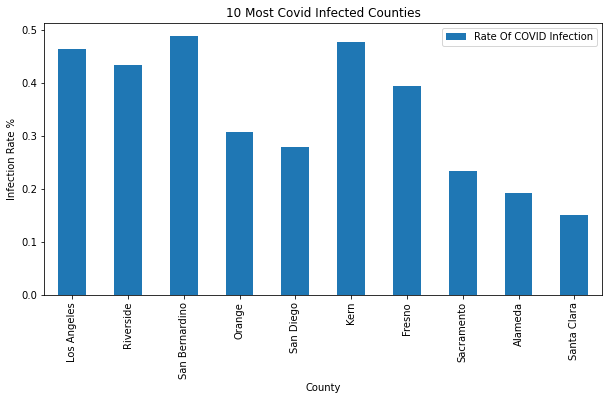

<Figure size 432x288 with 0 Axes>

In [13]:
#Crate and save Bar Plot showing Covid rate for 10 top Infected Counties (DHALL)
Top10COV = Top_10_Counties[["County","Rate Of COVID Infection"]]
Top10COV = Top10COV.set_index("County")


Top10COV.plot(kind="bar", figsize=(10,5))

plt.title("10 Most Covid Infected Counties")
plt.ylabel("Infection Rate %")
plt.xlabel("County")
plt.show()
plt.tight_layout()
plt.savefig('Resources/Top10COV.png')

In [14]:
# 14 Month Overall data for counties least hit with Covid cases Jan 2020 - Feb 2021
Bottom_10_Counties = pd.read_csv(Bottom_10_Counties_path)
Bottom_10_Counties

,County,Unemployment 14 - Month Average,Total Households,Total Persons,Total EBT Benefits,Total Cases 14 - Months,Total COVID Deaths 14 - Months,2019 Census Pop,Rate Of COVID Infection,Rate of COVID Related Death
0,Sierra,0.083,2387,3661,415910,152,0,3005,0.051,0.000
1,Alpine,0.111,993,1628,186371,272,0,1129,0.241,0.000
2,Trinity,0.082,15405,24986,3564280,1029,14,12285,0.084,0.001
3,Modoc,0.092,10631,19536,2268932,1040,9,8841,0.118,0.001
4,Mariposa,0.103,19830,33222,4136050,1476,28,17203,0.086,0.002
5,Plumas,0.116,18682,31530,3933718,1975,13,18807,0.105,0.001
6,Del Norte,0.094,43999,78317,9149026,3576,14,27812,0.129,0.001
7,Inyo,0.076,15179,27491,3485696,3851,146,18039,0.213,0.008
8,Mono,0.122,6973,11253,1503487,4526,26,14444,0.313,0.002
9,Siskiyou,0.102,57806,104270,12452990,5792,40,43539,0.133,0.001


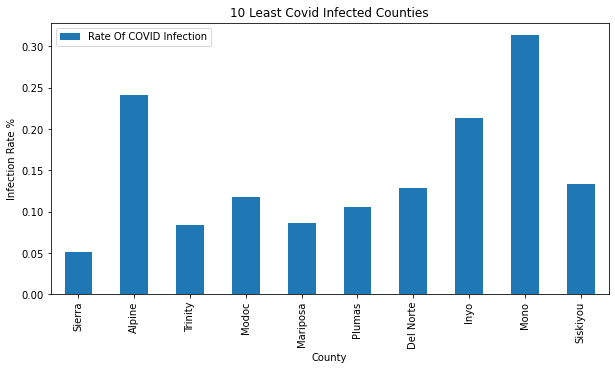

<Figure size 432x288 with 0 Axes>

In [15]:
#Crate and save Bar Plot showing Covid rate for 10 least Infected Counties (DHALL)
Bot10COV = Bottom_10_Counties[["County","Rate Of COVID Infection"]]
Bot10COV = Bot10COV.set_index("County")


Bot10COV.plot(kind="bar", figsize=(10,5))

plt.title("10 Least Covid Infected Counties")
plt.ylabel("Infection Rate %")
plt.xlabel("County")
plt.show()
plt.tight_layout()
plt.savefig('Resources/Bot10COV.png')

In [16]:
# Combine CalFresh, census and counties data into a single dataset (John)
# Combine CalFresh, census and counties data into a single dataset (DHALL)
Merged_CalFresh_Covid_Census_Data_path = 'Resources\Merged CalFresh_Covid_Census_Data.csv'

All_Merged_data = pd.read_csv(Merged_CalFresh_Covid_Census_Data_path)

All_Merged_data.head(10)

,County,Average of Unemployment Monthly,Sum of Households,Sum of Persons,Sum of EBT Cash,Sum of Cases,Sum of Deaths,2019 Census Pop,Rate Of Infection,Rate of Death
0,Alameda,0.084429,1101422,1838639,228188883,321021,4948,1671329,0.192075,0.002961
1,Alpine,0.110643,993,1628,186371,272,0,1129,0.240921,0.000000
2,Amador,0.089857,19852,34022,4453596,10604,158,39752,0.266754,0.003975
3,Butte,0.089286,247090,408275,50802411,41739,580,219186,0.190427,0.002646
4,Calaveras,0.077214,40857,70474,8902893,6348,130,45905,0.138286,0.002832
5,Colusa,0.165357,12452,25419,2941195,8056,59,21547,0.373880,0.002738
6,Contra Costa,0.085786,568920,1035354,129476190,247295,2671,1153526,0.214382,0.002316
7,Del Norte,0.094143,43999,78317,9149026,3576,14,27812,0.128578,0.000503
8,El Dorado,0.081286,101812,163038,20862927,29695,209,192843,0.153985,0.001084
9,Fresno,0.112500,1383558,3581392,358854819,393772,4980,999101,0.394126,0.004984


# Summary Statistics

## Line Chart 

In [17]:
# Show CA state covid cases over months using line plot. Years on x-axis and population on y-axis
# Timeframe: Jan 2020 to March 2021


In [18]:
# Graph trends amoungst various counties on a single plot. Pick 5, at least one urban area
# Timeframe: Jan 2020 to March 2021


In [19]:
# Correlation Rise of Covid and CalFresh (maybe unemployment) vs number of people receiving CalFresh aid.

### Bar Chart

In [20]:
# Number of Covid cases in all counties. Sort decending

In [21]:
# Number of Covid cases in top 10 counties. Sort decending